In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

from utils_week9to11 import LeNet5, train, test

In [3]:
batch_size = 128
epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

## Backdooring under Different Poisoning Ratios
> 区别于上一周的可见后门，不可见后门由于在训练过程中会实时更新后门触发器\
> 我们将不再预处理生成后门数据集，而是在训练过程中实时构建后门样本

- 不可见后门攻击的攻击框架与可见后门基本一致

- 攻击者会干预模型的训练和测试两阶段

- 在训练时投入一定比例的后门样本，在测试时将trigger添加在干净图片上发起攻击

建议使用的API：
- torch.ones_like(input, dtype, device)：生成一个元素值全为1、形如input的多维Tensor
- torch.ones(size, dtype, device)：生成一个元素值全为1的多维Tensor
- torch.norm(input, p)：计算input的L_p范数

In [4]:
# 在干净训练数据集上实时生成后门样本并进行训练，同步更新模型参数和后门trigger
def invisible_trigger_train(model, loader, criterion, optim_model, optim_trigger, trigger, target_label=3):
    model.train()
    train_loss, sample_num = 0., 0

    for inputs, labels in tqdm(loader):
        normal_inputs, normal_labels = inputs.to(device), labels.to(device)

        # TODO：基于正常样本生成后门样本
        backdoor_inputs = inputs + trigger
        backdoor_labels = torch.ones_like(labels) * target_label

        optim_model.zero_grad()
        optim_trigger.zero_grad()

        # TODO：分别计算
        # main_loss->模型在正常样本上的分类loss，
        # backdoor_loss->模型在后门样本上的分类loss，
        # reg_loss->正则化项（trigger的L2范数）
        main_loss = criterion(model(normal_inputs), normal_labels)

        backdoor_loss = criterion(model(backdoor_inputs), backdoor_labels)
        
        reg_loss = torch.norm(trigger)

        loss = main_loss + 0.5 * backdoor_loss + 0.1 * reg_loss
        loss.backward()
        
        optim_model.step()
        optim_trigger.step()

        sample_num += inputs.shape[0]
        train_loss += loss.item() * inputs.shape[0]
        # break

    train_loss /= sample_num    
    return train_loss

### 数据准备

In [5]:
train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
print('Clean train data is prepared.')

test_data = torchvision.datasets.MNIST(root='data/', train=False, transform=torchvision.transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
print('Clean test data is prepared.')

Clean train data is prepared.
Clean test data is prepared.


### 测试准备

In [6]:
# 在后门测试集上测试攻击成功率ASR
def test_backdoor(model, loader, trigger, device=None, target_label=3):
    device = next(model.parameters()).device if device is None else device
    model.eval()
    total_num = 0.
    correct_num = 0.
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # TODO：基于正常样本生成后门样本
            backdoor_inputs = inputs + trigger
            backdoor_labels = torch.ones_like(labels) * target_label
            
            outputs = model(backdoor_inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total_num += inputs.shape[0]
            correct_num += predicted.eq(backdoor_labels).sum().item()
    acc = correct_num / total_num * 100.
    return acc

### 模型训练及测试

**助教验收**：
- 3种trigger_lr设置下，最佳效果的test_acc > 95.0%、test_asr > 99.0%

In [7]:
# 在不同学习率下优化trigger并植入模型，再测试模型在干净测试集的正常性能
model_lr = 0.01
trained_models = []
invisible_triggers = []

for trigger_lr in [ 0.005, 0.01, 0.05]:
    print('##### Experiment on lr=%.3f #####' % trigger_lr)
    
    model = LeNet5()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # 生成不可见trigger（即全局扰动）
    trigger = torch.rand(28, 28).to(device)
    trigger.requires_grad = True

    # TODO：为模型和trigger分别设置优化器optim_model和optim_trigger
    optim_model = torch.optim.SGD(model.parameters(), lr=model_lr)
    optim_trigger = torch.optim.SGD([trigger], lr=trigger_lr)

    for epoch in range(epochs):
        # 生成后门并植入
        train_loss = invisible_trigger_train(model, train_loader, criterion, optim_model, optim_trigger, trigger)
        # 测试模型正常性能
        test_acc = test(model, test_loader)
        # 测试模型在后门样本上的攻击准确率
        test_asr = test_backdoor(model, test_loader, trigger)
        print('Epoch %d: train_loss %.4f, test_acc %.2f%%, test_asr %.2f%%, ' % (epoch, train_loss, test_acc, test_asr))
    trained_models.append(model)
    invisible_triggers.append((trigger_lr, trigger))

##### Experiment on lr=0.005 #####


100%|██████████| 79/79 [00:00<00:00, 120.04it/s]


Epoch 0: train_loss 3.7863, test_acc 71.88%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 123.78it/s]


Epoch 1: train_loss 2.2460, test_acc 87.56%, test_asr 99.87%, 


100%|██████████| 79/79 [00:00<00:00, 118.99it/s]


Epoch 2: train_loss 1.8898, test_acc 89.94%, test_asr 99.95%, 


100%|██████████| 79/79 [00:00<00:00, 120.74it/s]


Epoch 3: train_loss 1.7856, test_acc 92.00%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 109.81it/s]


Epoch 4: train_loss 1.7066, test_acc 93.16%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 116.88it/s]


Epoch 5: train_loss 1.6447, test_acc 94.40%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 119.10it/s]


Epoch 6: train_loss 1.5933, test_acc 94.80%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 122.76it/s]


Epoch 7: train_loss 1.5483, test_acc 95.49%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 121.50it/s]


Epoch 8: train_loss 1.5067, test_acc 95.89%, test_asr 99.93%, 


100%|██████████| 79/79 [00:00<00:00, 120.07it/s]


Epoch 9: train_loss 1.4734, test_acc 96.12%, test_asr 99.96%, 
##### Experiment on lr=0.010 #####


100%|██████████| 79/79 [00:00<00:00, 121.56it/s]


Epoch 0: train_loss 3.9875, test_acc 63.45%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 120.29it/s]


Epoch 1: train_loss 2.4409, test_acc 86.79%, test_asr 99.99%, 


100%|██████████| 79/79 [00:00<00:00, 121.36it/s]


Epoch 2: train_loss 1.9146, test_acc 90.84%, test_asr 99.90%, 


100%|██████████| 79/79 [00:00<00:00, 111.05it/s]


Epoch 3: train_loss 1.7721, test_acc 92.43%, test_asr 99.99%, 


100%|██████████| 79/79 [00:00<00:00, 113.89it/s]


Epoch 4: train_loss 1.6739, test_acc 92.60%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 118.17it/s]


Epoch 5: train_loss 1.5876, test_acc 94.11%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 117.57it/s]


Epoch 6: train_loss 1.5139, test_acc 95.55%, test_asr 99.98%, 


100%|██████████| 79/79 [00:01<00:00, 75.99it/s]


Epoch 7: train_loss 1.4448, test_acc 96.42%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 99.71it/s] 


Epoch 8: train_loss 1.3817, test_acc 96.50%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 108.20it/s]


Epoch 9: train_loss 1.3228, test_acc 96.72%, test_asr 99.99%, 
##### Experiment on lr=0.050 #####


100%|██████████| 79/79 [00:00<00:00, 100.36it/s]


Epoch 0: train_loss 3.9940, test_acc 44.00%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 102.91it/s]


Epoch 1: train_loss 2.3950, test_acc 85.19%, test_asr 99.57%, 


100%|██████████| 79/79 [00:00<00:00, 106.34it/s]


Epoch 2: train_loss 1.5039, test_acc 88.84%, test_asr 99.97%, 


100%|██████████| 79/79 [00:00<00:00, 108.21it/s]


Epoch 3: train_loss 1.2384, test_acc 91.09%, test_asr 99.99%, 


100%|██████████| 79/79 [00:00<00:00, 109.95it/s]


Epoch 4: train_loss 0.8893, test_acc 93.23%, test_asr 99.97%, 


100%|██████████| 79/79 [00:00<00:00, 109.67it/s]


Epoch 5: train_loss 0.7306, test_acc 94.30%, test_asr 99.76%, 


100%|██████████| 79/79 [00:00<00:00, 106.66it/s]


Epoch 6: train_loss 0.5855, test_acc 94.98%, test_asr 99.82%, 


100%|██████████| 79/79 [00:00<00:00, 109.37it/s]


Epoch 7: train_loss 0.5249, test_acc 94.82%, test_asr 99.59%, 


100%|██████████| 79/79 [00:00<00:00, 86.22it/s]


Epoch 8: train_loss 0.4169, test_acc 95.72%, test_asr 99.81%, 


100%|██████████| 79/79 [00:00<00:00, 105.49it/s]

Epoch 9: train_loss 0.4190, test_acc 95.30%, test_asr 99.87%, 


## Demo Backdoor Visualization
- 可视化trigger

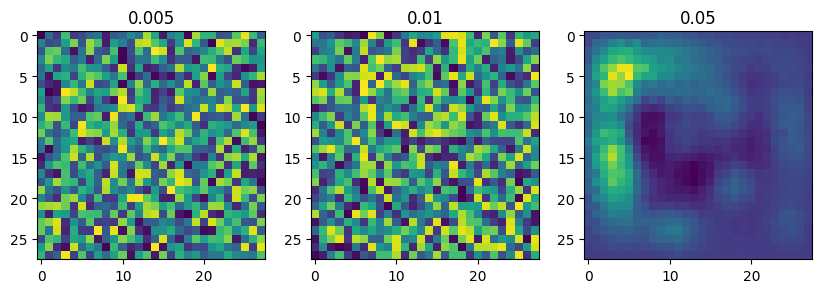

In [8]:
fig = plt.figure(figsize=(10, 3))
for idx, triggers in enumerate(invisible_triggers):
    ax = fig.add_subplot(1, 3, idx+1)
    
    trigger_lr, trigger = triggers
    ax.set_title(trigger_lr)
    plt.imshow(trigger.detach().numpy())

- 可视化投毒样本

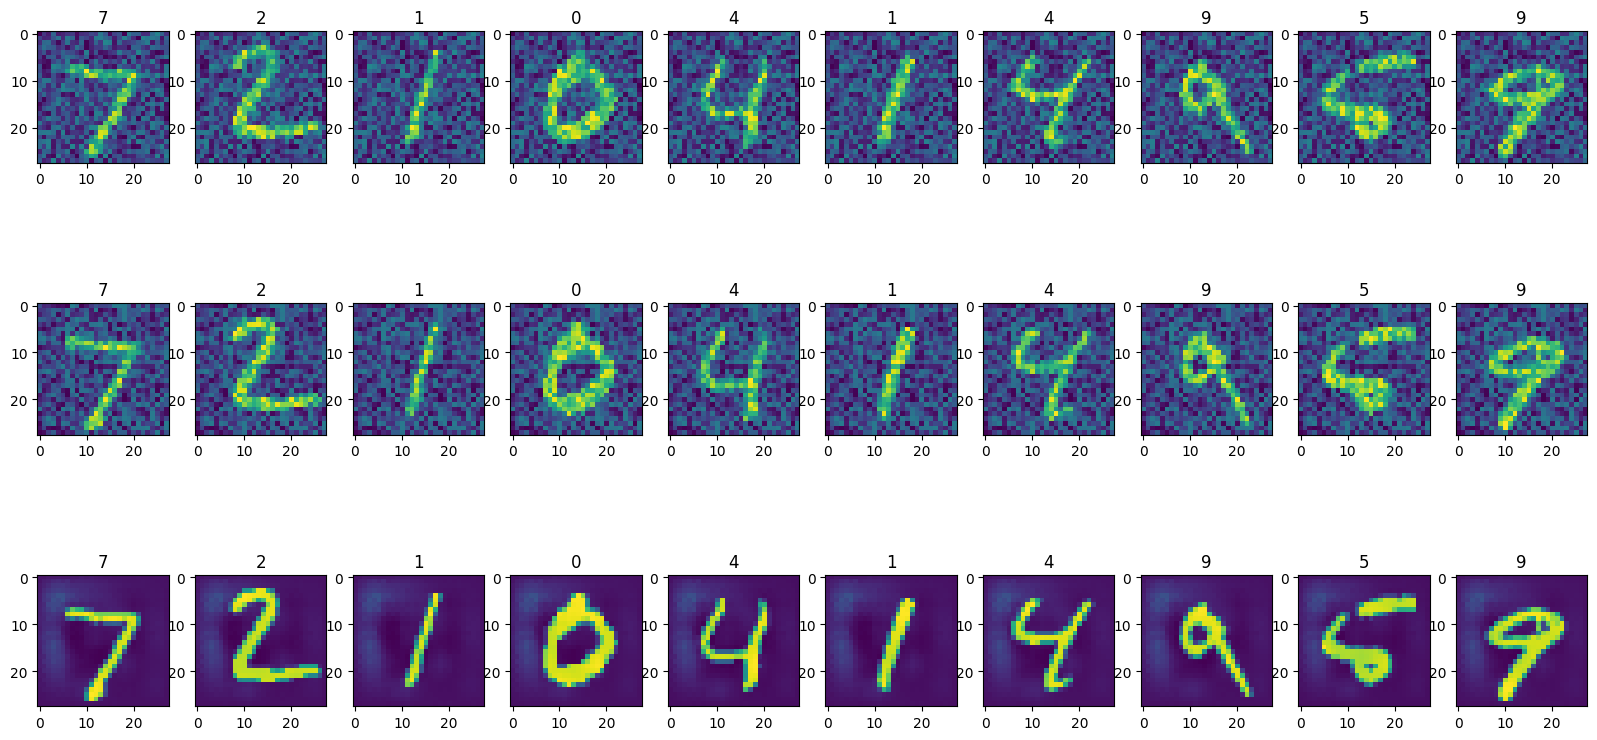

In [13]:
fig = plt.figure(figsize=(20, 10))
for idx, trigger in enumerate(invisible_triggers):

    for i in range(10):
        ax = fig.add_subplot(3, 10, (idx)*10+i+1)
        x = test_data[i][0] + trigger[1].detach().numpy()
        y = test_data[i][1]
        ax.set_title(str(y))
        plt.imshow(x[0])  # 可视化x唯一色彩通道的像素值
    